In [1]:
import os
import pandas as pd
from azure.identity.aio import ManagedIdentityCredential
cred = ManagedIdentityCredential()
opts = {'account_name': 'datalakestorage7nrw9r', 'credential': cred, 'anon': False}
folder_path = "abfs://datalakegen2filesystem/analytics/connectedcar/chenha01/Churn/"

train = pd.read_csv(folder_path + 'trainOneMonth.csv', delimiter=',', storage_options=opts)
test = pd.read_csv(folder_path + 'testOneMonth.csv', delimiter=',', storage_options=opts)
valid = pd.read_csv(folder_path + 'validOneMonth.csv', delimiter=',', storage_options=opts)

In [2]:
from sklearn import linear_model

In [3]:
OneMonthbins = pd.read_csv(folder_path + 'OneMonthbinsMixOldNew.csv', delimiter=',', storage_options=opts)
# convert OneMonthbins into dictionary, with variable as key, the vraiable's dataframe as value
columns = OneMonthbins['variable'].unique()
OneMonthbins_dict = {}
for col in columns:
    OneMonthbins_dict[col] = OneMonthbins[OneMonthbins['variable'] == col]
# apply OneMonthbins
import scorecardpy as sc
train_woe = sc.woebin_ply(train, OneMonthbins_dict)
train_woe['OneMonth_target'] = train['OneMonth_target']
valid_woe = sc.woebin_ply(valid, OneMonthbins_dict)
valid_woe['OneMonth_target'] = valid['OneMonth_target']
test_woe = sc.woebin_ply(test, OneMonthbins_dict)
test_woe['OneMonth_target'] = test['OneMonth_target']

[INFO] converting into woe values ...
Woe transformating on 51760 rows and 1640 columns in 00:03:33
[INFO] converting into woe values ...
Woe transformating on 22184 rows and 1640 columns in 00:01:27
[INFO] converting into woe values ...
Woe transformating on 15846 rows and 1640 columns in 00:01:03


In [4]:
# Read the GarageAttributes file
import os
with open(os.getcwd() + '/GarageAttributes', 'r') as file:
    garage_attributes = file.read().splitlines()
# Print the list of garage attribute names
print(garage_attributes)

['countallvehicles', 'countallvehiclesaddedpast1mth', 'countallvehiclesaddedpast2mths', 'countallvehiclesaddedpast3mths', 'countallvehiclesaddedpast6mths', 'countallvehiclesaddedpast12mths', 'countallvehiclesaddedpast24mths', 'countallvehiclesaddedpast36mths', 'countallvehiclesaddedpast48mths', 'countallvehiclesaddedpast60mths', 'countallvehiclespurchasednew', 'countallvehiclespurchasednewaddedpast1mth', 'countallvehiclespurchasednewaddedpast2mths', 'countallvehiclespurchasednewaddedpast3mths', 'countallvehiclespurchasednewaddedpast6mths', 'countallvehiclespurchasednewaddedpast12mths', 'countallvehiclespurchasednewaddedpast24mths', 'countallvehiclespurchasednewaddedpast36mths', 'countallvehiclespurchasednewaddedpast48mths', 'countallvehiclespurchasednewaddedpast60mths', 'countallvehiclespurchasedused', 'countallvehiclespurchasedusedaddedpast1mth', 'countallvehiclespurchasedusedaddedpast2mths', 'countallvehiclespurchasedusedaddedpast3mths', 'countallvehiclespurchasedusedaddedpast6mths',

In [5]:
# get value of woe when variable is 'statecode' and bin is missing
colum = 'statecode'
missing_woe = OneMonthbins[OneMonthbins['variable'] == colum]['woe'].iloc[0]
# fill missing values in 'statecode' with missing_woe
colum = colum + '_woe'
train_woe[colum] = train_woe[colum].fillna(missing_woe)
valid_woe[colum] = valid_woe[colum].fillna(missing_woe)
test_woe[colum] = test_woe[colum].fillna(missing_woe)

In [51]:
# Train
base_features = ["statecode_woe", "months_paying_woe", "combined_age_woe", "base_price_woe", "appfeatures_woe"]

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['statecode_woe', 'months_paying_woe', 'combined_age_woe', 'base_price_woe', 'appfeatures_woe']
train lift: 3.6679513509766206
test lift: 3.412203808180536


In [12]:
# Train
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['state_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesgasaddedpast6mths_woe']
train lift: 3.9655643231592594
test lift: 3.4352116503117918


In [13]:
# Train
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['state_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']
train lift: 4.0769697212791005
test lift: 3.521669111284109


In [6]:
# Train
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

/tmp/ipykernel_42777/2192605326.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_woe['prob'] = prob
/tmp/ipykernel_42777/2192605326.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
/tmp/ipykernel_42777/2192605326.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

['state_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']
train lift: 4.0769697212791005
test lift: 3.521669111284109


/tmp/ipykernel_42777/2192605326.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
/tmp/ipykernel_42777/2192605326.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']


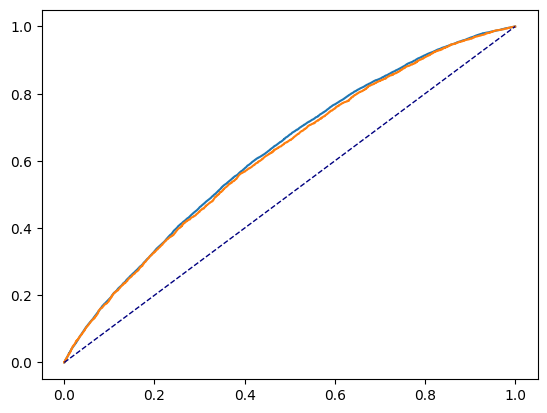

In [9]:
# get roc curve for the model on both train and test
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(train_woe['OneMonth_target'], model.predict_proba(train_woe[base_features])[:,1])
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(test_woe['OneMonth_target'], model.predict_proba(test_woe[base_features])[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.show()

In [11]:
# get f1 score for the model on both train and test
from sklearn.metrics import f1_score
print('train f1:', f1_score(train_woe['OneMonth_target'], model.predict(train_woe[base_features])))
print('test f1:', f1_score(test_woe['OneMonth_target'], model.predict(test_woe[base_features])))

train f1: 0.0021160576218767803
test f1: 0.002809646452821353


In [19]:
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']
dict = {}
best_rate = 0
best_col = ''
for col in base_features:
    base_features.remove(col)
    model = linear_model.LogisticRegression()
    model.fit(train_woe[base_features], train_woe['OneMonth_target'])
    # return probability of each row in test
    prob = model.predict_proba(valid_woe[base_features])
    # return probability of 1
    prob = [p[1] for p in prob]
    # sort prob in order
    valid_woe['prob'] = prob
    valid_woe.sort_values(by='prob', ascending=True, inplace=True)
    # group rows into 10 groups with same number of rows
    valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
    valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

    # group by group, calculate the sum of OneMonth_target and count of OneMonth_target
    test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
    # calculate rate of OneMonth_target by OneMonth_target /  pred
    test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
    # get rate of OneMonth_target from group as 0
    rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
    rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
    rate_9 / rate_0
    print(col, rate_9 / rate_0)
    dict[col] = rate_9 / rate_0
    if rate_9 / rate_0 > best_rate:
        best_rate = rate_9 / rate_0
        best_col = col
    # add the column back to first position
    base_features.insert(0, col)

state_woe 3.9556385375618253
months_paying_woe 2.4978584074729797
age_drv_woe 3.5104633536810197
base_price_woe 3.73567335243553
appfeatures_woe 3.333636666253031
countallvehiclesgasaddedpast6mths_woe 3.9986004230957817
curraddrmedianincome_woe 3.9655643231592594


In [35]:
# find any column with state in it
for col in train.columns:
    if 'age' in col:
        print(col)

primary_package_id
countallvehiclesvolkswagen
countactivevehiclesvolkswagen
countallvehiclespurchasednewvolkswagen
countactivevehiclespurchasednewvolkswagen
countallvehiclespurchasedusedvolkswagen
countactivevehiclespurchasedusedvolkswagen
countdisposedvehiclesvolkswagen
countdisposedvehiclespurchasednewvolkswagen
countdisposedvehiclespurchasedusedvolkswagen
pctactivevehiclesvolkswagenderived
special_usage_flag
exact_age_p1
combined_age_indicator
age_in_years_drv_numeric
home_land_square_footage
home_land_front_footage
home_land_depth_footage
home_building_square_footage
home_base_square_footage
oo_home_mortgage_amt
mortgage_term_in_months
refi_mortgage_amt
mortgage_amount_in_thousands2
dl_cppm_mortgage_term
cfi_mortgage_refinance_score
inq_mortgage
v1_prospectage
v1_hhteenagermmbrcnt
v1_hhmiddleagemmbrcnt
v1_raateenagemmbrcnt
v1_raamiddleagemmbrcnt
source_usage
age_drv
mortgage_age
age_16_24_in_hh
coveragetier
mortgage_protection_model
mortgage_protection_decile
combined_age
combined_

In [48]:
import numpy as np
from scipy import stats
import pandas as pd

# p value
# remove rows wuth missing values
valid_woe.dropna(inplace=True)
params = np.append(model.intercept_, model.coef_)
predictions = model.predict(valid_woe[base_features])
newX = np.append(np.ones((len(valid_woe), 1)), valid_woe[base_features], axis=1)
MSE = (sum((valid_woe['OneMonth_target'] - predictions) ** 2)) / (len(newX) - len(newX[0]))

# Compute the dot product
matrix = np.dot(newX.T, newX)

# Check if the matrix is singular
if np.linalg.det(matrix) != 0:
    inv_matrix = np.linalg.inv(matrix)
else:
    inv_matrix = np.linalg.pinv(matrix)

var_b = MSE * inv_matrix.diagonal()
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

# summary
summary = pd.DataFrame()
summary["features"] = ['intercept'] + base_features
summary["coefficients"] = params
summary["p_values"] = p_values
summary

,features,coefficients,p_values
0,intercept,-1.170349,0.000000e+00
1,statecode_woe,0.963276,0.000000e+00
2,months_paying_woe,0.895269,0.000000e+00
3,combined_age_woe,0.816164,0.000000e+00
4,base_price_woe,0.738878,0.000000e+00
5,appfeatures_woe,1.303823,0.000000e+00
6,vehicle_age_woe,0.186623,1.116884e-13
